In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'iz.jizni'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(22378, 7)
CPU times: user 2.79 s, sys: 16 ms, total: 2.8 s
Wall time: 2.8 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/dino/,NaN,Мир,Похищено уникальное яйцо динозавра,Неизвестные злоумышленники похитили из музея г...,Из жизни
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/boxing/,NaN,Мир,Боксерский поединок между мужчиной и женщиной ...,36-летняя Маргарет Макгрегор объявлена победит...,Из жизни


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 112 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 3.22 s, sys: 25.2 ms, total: 3.25 s
Wall time: 3.26 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/dino/,NaN,Мир,Похищено уникальное яйцо динозавра,неизвестные злоумышленники похитили из музея г...,Из жизни,"[(1999, 10, 06)]",1999,10
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/boxing/,NaN,Мир,Боксерский поединок между мужчиной и женщиной ...,летняя маргарет макгрегор объявлена победитель...,Из жизни,"[(1999, 10, 11)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 32.3 s, sys: 3.73 ms, total: 32.3 s
Wall time: 32.3 s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1min 12s, sys: 56.3 ms, total: 1min 12s
Wall time: 1min 12s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[неизвестный, злоумышленник, похитить, музей, ..."
1,1,1999,10,"[летний, маргарета, макгрегор, объявить, побед..."


In [14]:
print(df.shape)
df.isnull().sum()

(22378, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 266 ms, sys: 36 ms, total: 302 ms
Wall time: 308 ms


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/iz.jizni", num_batches=23)
CPU times: user 10.7 s, sys: 620 ms, total: 11.3 s
Wall time: 4.07 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=5d68e964-d246-4630-a410-1e645b8580ab, num_entries=17892)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.1093931570649147
	SparsityPhiScore: 0.2393687665462494
	PerplexityScore: 5171.85693359375
	time: 0:00:58.657459
#topic 3.........
	SparsityThetaScore: 0.20993833243846893
	SparsityPhiScore: 0.36007753014564514
	PerplexityScore: 4765.1689453125
	time: 0:01:07.145599
#topic 4.........
	SparsityThetaScore: 0.30307668447494507
	SparsityPhiScore: 0.43997785449028015
	PerplexityScore: 4473.0322265625
	time: 0:01:08.962523
#topic 5.........
	SparsityThetaScore: 0.3641969859600067
	SparsityPhiScore: 0.5065891742706299
	PerplexityScore: 4200.171875
	time: 0:01:14.032202
#topic 6.........
	SparsityThetaScore: 0.43194952607154846
	SparsityPhiScore: 0.5470007658004761
	PerplexityScore: 4014.58056640625
	time: 0:01:18.657475
#topic 7.........
	SparsityThetaScore: 0.46604445576667786
	SparsityPhiScore: 0.592714786529541
	PerplexityScore: 3877.149658203125
	time: 0:01:23.967516
#topic 8.........
	SparsityThetaScore: 0.5116632580757141
	SparsityPhiScore: 0.6177

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

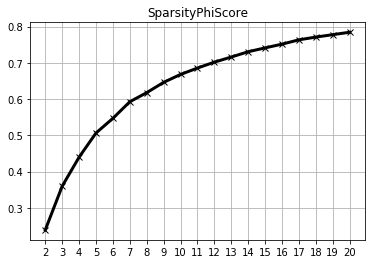

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}

Text(0.5, 1.0, 'SparsityThetaScore')

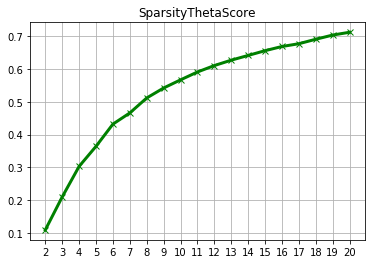

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}

Text(0.5, 1.0, 'PerplexityScore')

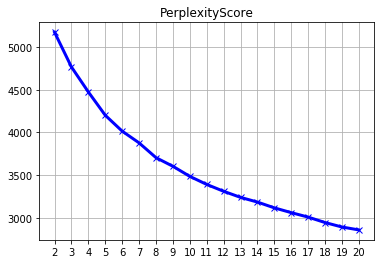

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[5171.85693359375,
 4765.1689453125,
 4473.0322265625,
 4200.171875,
 4014.58056640625,
 3877.149658203125,
 3704.4267578125,
 3603.41357421875,
 3485.393310546875,
 3390.924560546875,
 3310.852783203125,
 3239.70947265625,
 3184.58447265625,
 3116.91845703125,
 3060.926513671875,
 3008.7333984375,
 2945.043701171875,
 2892.769775390625,
 2858.912353515625]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 2, 0.4: 2, 0.5: 4, 0.6: 7, 0.7: 2}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7164357900619507
	SparsityPhiScore: 0.7850435972213745
	PerplexityScore: 2882.40673828125


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['килограмм' 'вес' 'исследование' 'пиво' 'бутылка' 'напиток'
 'великобритания' 'британец' 'каждый' 'алкоголь']
topic_1: ['дочь' 'отец' 'сын' 'семья' 'девочка' 'мальчик' 'родитель' 'родиться'
 'мать' 'матерь']
topic_2: ['ресторан' 'заведение' 'блюдо' 'посетитель' 'продукт' 'мясо' 'еда' 'яйцо'
 'съесть' 'кафе']
topic_3: ['конкурс' 'рекорд' 'участие' 'мисс' 'участник' 'мероприятие'
 'соревнование' 'книга' 'организатор' 'игра']
topic_4: ['власть' 'решение' 'великобритания' 'право' 'запретить' 'закон' 'россия'
 'запрет' 'совет' 'евро']
topic_5: ['вода' 'метр' 'акула' 'берег' 'остров' 'спасатель' 'километр' 'упасть'
 'пляж' 'высота']
topic_6: ['магазин' 'продажа' 'игрушка' 'кукла' 'марка' 'марихуана' 'выпустить'
 'товар' 'фирма' 'рекламный']
topic_7: ['птица' 'крокодил' 'змея' 'поймать' 'длина' 'рыба' 'вид' 'специалист'
 'питон' 'рептилия']
topic_8: ['обвинение' 'тюрьма' 'подать' 'адвокат' 'бывший' 'джексон' 'актёр'
 'развод' 'судья' 'решение']
topic_9: ['полицейский' 'машина' 'авто

### get topics-docs matrix

shape theta: (20, 22378)


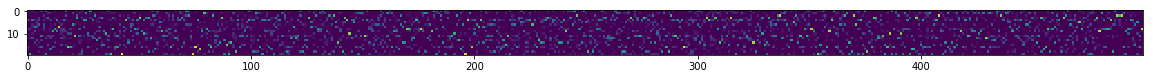

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
9000,0.021615,0.000000,0.0,0.070109,0.117824,0.000000,0.0,0.000000,0.148308,0.001562,0.055172,0.0,0.07411,0.000000,0.012911,0.000000,0.150252,0.000000,0.000000,0.348137
9001,0.000000,0.181718,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.110946,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.707336,0.000000,0.000000
9002,0.000000,0.000000,0.0,0.000000,0.000000,0.048271,0.0,0.155774,0.000000,0.717230,0.013362,0.0,0.00000,0.000000,0.000000,0.034785,0.000000,0.000000,0.000000,0.030578
9003,0.049227,0.000000,0.0,0.000000,0.000000,0.288744,0.0,0.000000,0.000000,0.260887,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401141,0.000000
9004,0.000000,0.045397,0.0,0.000000,0.000000,0.000000,0.0,0.195936,0.000000,0.016488,0.000000,0.0,0.00000,0.146306,0.119122,0.394653,0.000000,0.000000,0.000000,0.082099


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.046904,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.245501,0.000000,0.000000,0.552063,0.0
1,1,1999,10,0.000000,0.000000,0.000000,0.402319,0.363808,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.123722,0.110152,0.000000,0.0
2,2,1999,10,0.000290,0.353741,0.000000,0.128556,0.517413,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,3,1999,10,0.397217,0.000000,0.000000,0.000000,0.396486,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,4,1999,10,0.000000,0.036584,0.007277,0.000000,0.338305,0.0,0.0,...,0.033381,0.0,0.0,0.0,0.0,0.238130,0.000000,0.000000,0.059967,0.0


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 8      0.043038  0.007794  0.000000  0.000000  0.034337  0.000000   
     9      0.114615  0.574951  0.155080  0.123721  0.517810  0.009497   
     10     0.445099  0.543868  0.054181  0.530876  1.920854  0.309527   
     11     0.451030  0.126042  0.036578  0.323413  1.766191  0.000000   
     12     0.278862  0.085085  0.000000  0.243111  1.324249  0.474690   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 8      0.040289  0.000000  0.040531  0.080516  0.014674  0.000000   
     9      0.172504  0.072873  0.000000  0.140992  0.000000  0.226413   
     10     0.615044  0.192813  0.406973  0.174897  0.033381  0.000000   
     11     0.491155  0.000000  0.296978  0.000000  0.557097  0.068517   
     12     0.151272  0.438682  0.539860  0.044616  0.548573  0.000000   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 8      0.121780  0.000000  0.000000  0.000000  0.000000  0.530360   
     9      0.171429  0.164139  0.064652  0.179783  0.859327  0.019743   
     10     0.028740  0.000796  0.000000  0.483632  0.133315  0.110152   
     11     0.307704  0.147284  0.000000  0.000000  0.240622  0.000000   
     12     0.558019  0.248339  0.170726  0.019123  0.000000  0.509432   

            topic_18  topic_19  
year month                      
1999 8      0.086680  0.000000  
     9      0.291893  0.140578  
     10     1.015853  0.000000  
     11     0.000000  0.187391  
     12     0.365362  0.000000

### straightforward matrix heatmap

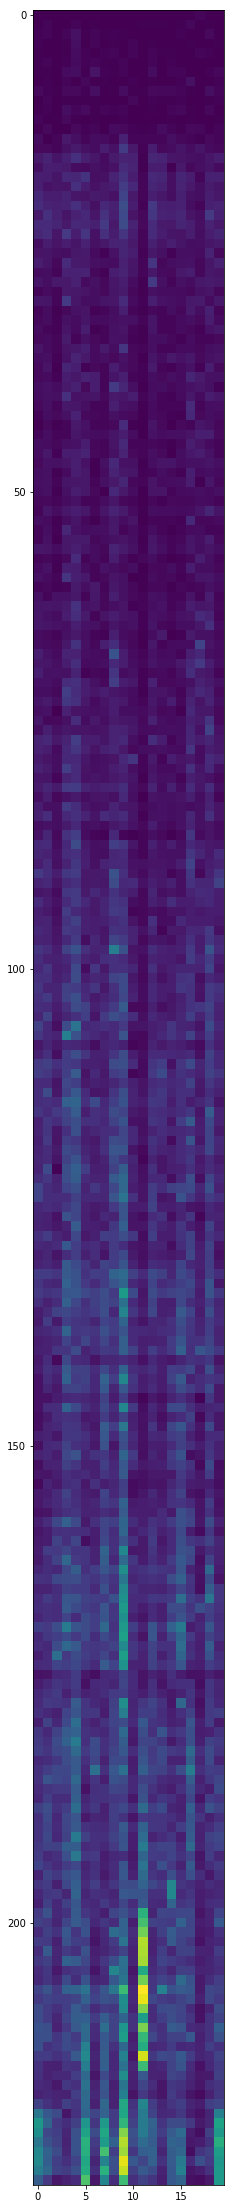

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [40]:
import pygal
from IPython.display import SVG, HTML

In [41]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [43]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [44]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(22378, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.046904,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.245501,0.000000,0.000000,0.552063,0.0
1,1,1999,10,0.000000,0.000000,0.000000,0.402319,0.363808,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.123722,0.110152,0.000000,0.0
2,2,1999,10,0.000290,0.353741,0.000000,0.128556,0.517413,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,3,1999,10,0.397217,0.000000,0.000000,0.000000,0.396486,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,4,1999,10,0.000000,0.036584,0.007277,0.000000,0.338305,0.0,0.0,...,0.033381,0.0,0.0,0.0,0.0,0.238130,0.000000,0.000000,0.059967,0.0


In [29]:
joined.to_csv(f'''./data/topicsProbability/{'-'.join(name_dataset.split('.'))}.csv''',index=False)

In [46]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.036445,0.000000,0.059208,0.0,...,0.0,0.000000,0.000000,0.0,0.376490,0.000000,0.000000,0.488673,0.0,1999-10-01
1,1,1,1999,10,0.000000,0.000000,0.000000,0.428355,0.382230,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.092973,0.096442,0.000000,0.0,1999-10-01
2,2,2,1999,10,0.067835,0.430300,0.000000,0.022577,0.479287,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1999-10-01
3,3,3,1999,10,0.578976,0.000000,0.000000,0.000000,0.140776,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1999-10-01
4,4,4,1999,10,0.000000,0.000117,0.000000,0.000000,0.378134,0.0,...,0.0,0.061084,0.190827,0.0,0.256969,0.000000,0.000000,0.004340,0.0,1999-10-01


In [47]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(537072, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [48]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(447560, 3)


topic_8     22378
topic_7     22378
topic_2     22378
topic_19    22378
topic_9     22378
topic_18    22378
topic_10    22378
topic_13    22378
topic_6     22378
topic_16    22378
topic_0     22378
topic_5     22378
topic_15    22378
topic_17    22378
topic_11    22378
topic_3     22378
topic_14    22378
topic_4     22378
topic_12    22378
topic_1     22378
Name: topic, dtype: int64

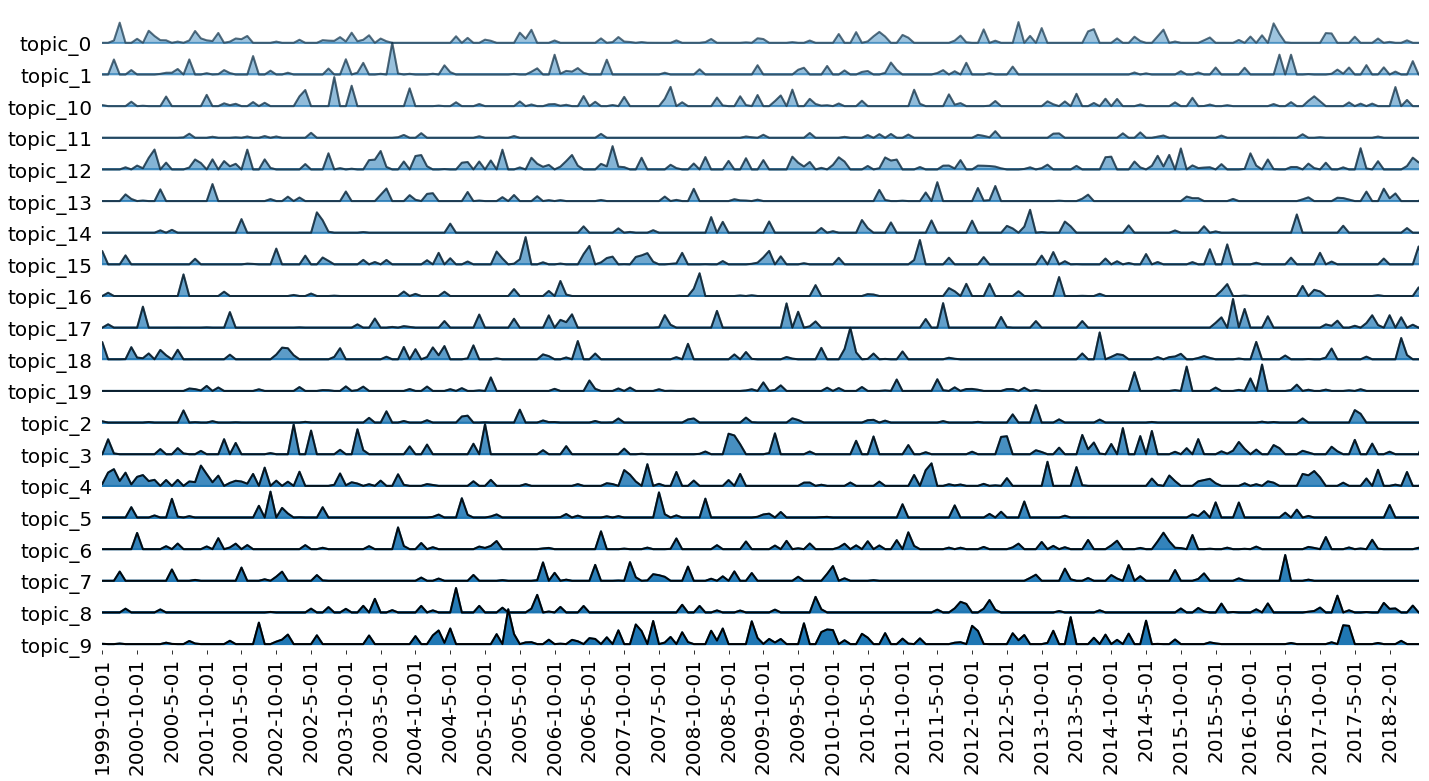

In [49]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [50]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")